## 机器翻译与数据集

机器翻译：是指将序列从一种语言自动翻译成另外一种语言，是输入序列转换成输出序列的序列转换模型的核心问题

In [15]:
import os
import torch
from d2l import torch as d2l

### 下载和预处理数据集

“英－法”数据集，数据集中的每一行都是制表符分隔的文本序列对， 序列对由英文文本序列和翻译后的法语文本序列组成。 请注意，每个文本序列可以是一个句子， 也可以是包含多个句子的一个段落。 在这个将英语翻译成法语的机器翻译问题中， 英语是源语言（source language）， 法语是目标语言（target language）。


In [16]:
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip',
                           '94646ad1522d915e7b0f9296181140edcf86a4f5')
def read_data_nmt():
    """载入“英语－法语”数据集"""
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r',
             encoding='utf-8') as f:
        return f.read()

raw_text = read_data_nmt()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



In [17]:
# 使用空格代替不间断的空格，使用小写字母替换大写字母，在单词和标注符号之间插入空格


def preprocess_nmt(text):
    
    def no_space(char, prev_char):
        """当前char时标点符号并且前面的char不是空的 """
        return char in set(",.!?") and prev_char !=" "

    # 使用空格代替不间断空格，使用小写字母代替大写字母
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # 在单词和标点符号之间插入空格
    out = [" "+ char if i>0 and no_space(char,text[i-1]) else char 
           for i,char in enumerate(text)]
    
    return ''.join(out)

text = preprocess_nmt(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


### 词元化

在机器翻译中，我们更喜欢单词级词元化（先进的模型可能采用更高级的词元化技术）。

其中每个词元要么是一个词，要么是一个标点符号。

In [18]:
def tokenize_nmt(text, num_examples=None):

    source ,target = [],[]
    for i,line in enumerate(text.split("\n")):

        if num_examples and i>num_examples:
            break
        parts = line.split("\t")        # 一个英语对应一个法语，并且中间用\t隔开（英法之间用 \t隔开）
        if len(parts)==2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))     
    return source,target
source, target = tokenize_nmt(text)
source[:6], target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

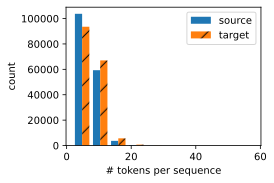

In [19]:
#让我们绘制每个文本序列所包含的词元数量的直方图。 
#在这个简单的“英－法”数据集中，大多数文本序列的词元数量少于20个。意思就是每一个列表里面的数少于20个。
# 开始一般都是两个，后面是句子有很多个
def show_list_len_pair_hist(legend, xlabel, ylabel, xlist, ylist):
    """绘制列表长度对的直方图"""
    d2l.set_figsize()
    _, _, patches = d2l.plt.hist(
        [[len(l) for l in xlist], [len(l) for l in ylist]])
    d2l.plt.xlabel(xlabel)
    d2l.plt.ylabel(ylabel)
    for patch in patches[1].patches:
        patch.set_hatch('/')
    d2l.plt.legend(legend)

show_list_len_pair_hist(['source', 'target'], '# tokens per sequence',
                        'count', source, target);

### 词表

由于机器翻译数据集由语言对组成， 因此我们可以分别为源语言和目标语言构建两个词表。 使用单词级词元化时，词表大小将明显大于使用字符级词元化时的词表大小。 为了缓解这一问题，这里我们将出现次数少于2次的低频率词元 视为相同的未知（“\<unk>”）词元。 除此之外，我们还指定了额外的特定词元， 例如在小批量时用于将序列填充到相同长度的填充词元（“\<pad>”）， 以及序列的开始词元（“\<bos>”）和结束词元（“\<eos>”）。 这些特殊词元在自然语言处理任务中比较常用。

In [20]:
src_vocab = d2l.Vocab(source, min_freq=2,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

10012

### 加载数据集

在之前的语言模型中，序列样本都有一个固定的长度，无论这个样本是一个句子的一部分还是跨越了多个句子的一个片断。这个固定长度都是由 num_steps 参数指定的。

在机器翻译中，每个样本都是由源和目标组成的文本序列对，其中每个文本序列对可能具有不同的长度。

为了提高计算效率，我们仍可以通过截断和填充方式实现一次只处理一个小批量的文本序列。假设同一个小批量中每个序列都应该具有相同的长度num_steps,那么如果文本序列的次元数目少于num_steps，我们将继续在其末尾添加特定的 \<pad>。直到其长度为num_steps；反之，我们将截断文本序列，只取其前num_steps个词元，并且丢弃剩余的词元。

In [21]:
#@save
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列"""
    if len(line) > num_steps:
        return line[:num_steps]  # 截断
    return line + [padding_token] * (num_steps - len(line))  # 填充

truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

现在我们定义一个函数，可以将文本序列 转换成小批量数据集用于训练。 

我们将特定的“\<eos>”词元添加到所有序列的末尾， 用于表示序列的结束。 当模型通过一个词元接一个词元地生成序列进行预测时， 生成的“\<eos>”词元说明完成了序列输出工作。 

此外，我们还记录了每个文本序列的长度， 统计长度时排除了填充词元， 在稍后将要介绍的一些模型会需要这个长度信息。

In [22]:
def build_array_nmt(lines, vocab, num_steps):
    """将机器翻译的文本序列转换成小批量"""
    
    lines = [vocab[l] for l in lines]
    lines = [l+[vocab["<eos>"]] for l in lines]
    array = torch.tensor(
        [truncate_pad(l,num_steps,vocab['<pad>']) for l in lines]
    )
    
    valid_len = (array != vocab['<pad']).type(torch.int32).sum(1)   # pad之后的不合法
    return array, valid_len

###  训练模型

In [23]:
#@save
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """返回翻译数据集的迭代器和词表"""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

In [24]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', X.type(torch.int32))
    print('X的有效长度:', X_valid_len)
    print('Y:', Y.type(torch.int32))
    print('Y的有效长度:', Y_valid_len)
    break

X: tensor([[  6,   0,   4,   3,   1,   1,   1,   1],
        [111,  23,   4,   3,   1,   1,   1,   1]], dtype=torch.int32)
X的有效长度: tensor([7, 8])
Y: tensor([[21,  0,  4,  3,  1,  1,  1,  1],
        [ 0,  5,  3,  1,  1,  1,  1,  1]], dtype=torch.int32)
Y的有效长度: tensor([7, 7])


## 序列到序列学习Seq2Seq

<img src = "photo/seq1.png">

<img src = "photo/seq2.png">

<img src = "photo/seq3.png">

In [25]:
import collections
import math
import torch
from torch import nn
from d2l import torch as d2l

### 编码器

我们使用了嵌入层（embedding layer） 来获得输入序列中每个词元的特征向量。 嵌入层的权重是一个矩阵， 其行数等于输入词表的大小（vocab_size）， 其列数等于特征向量的维度（embed_size）。 对于任意输入词元的索引i， 嵌入层获取权重矩阵的第i行（从0开始）以返回其特征向量。 另外，本文选择了一个多层门控循环单元来实现编码器。

In [26]:

class Seq2SeqEncoder(d2l.Encoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2SeqEncoder,self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,dropout=dropout)
        
    def forward(self,X,*args):
        # 输出 'X' 的形状：batch_size,num_steps,embed_size
        X = self.embedding(X)
        X = X.permute(1,0,2)        # 换位置
        output,state = self.rnn(X)
        return output,state
    

In [27]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)      
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)   # batch_size,序列长度（句子长度）
output, state = encoder(X)
output.shape

torch.Size([7, 4, 16])

7代表每一个时刻，4代表batch_size,16代表隐藏层个数

In [28]:
state.shape

torch.Size([2, 4, 16])

2代表有2层,4代表batch_size,16代表隐藏层大小

### 解码器

In [29]:
class Seq2SeqDecoder(d2l.Decoder):
    def __init__(self, vocab_size,embed_size,num_hiddens, num_layers,dropout=0,**kwargs):
        super(Seq2SeqDecoder,self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.rnn = nn.GRU(embed_size+num_hiddens,num_hiddens,num_layers,dropout=dropout)
        
        self.dense = nn.Linear(num_hiddens,vocab_size)
        
    def init_state(self, enc_outputs, *args):   # enc_outputs时 output，state
        """最后一个时间步的state，做成decoder的state"""
        return enc_outputs[1]
    
    def forward(self,X,state):
        
        X = self.embedding(X).permute(1,0,2)
        
        context = state[-1].repeat(X.shape[0],1,1)              # state[-1]最后一层的最后时间的输出
        X_and_context = torch.concat((X,context),2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        # output的形状:(batch_size,num_steps,vocab_size)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output, state
    

In [30]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

### 损失函数

 特定的填充词元被添加到序列的末尾， 因此不同长度的序列可以以相同形状的小批量加载。 但是，我们应该将填充词元的预测排除在损失函数的计算之外。

In [31]:
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    
    maxlen = X.size(1)      # 获取序列长度
    # [None,:]可以将一维数组转换为二维数组
    mask = torch.arange((maxlen),dtype=torch.float32,device=X.device)[None,:]<valid_len[:,None]
    
    X[~mask] = value        # ~的作用时取反，false变成0
    return X
    

In [32]:
X = torch.tensor([[1, 2, 3], [4, 5, 6]])
print(X.size())
sequence_mask(X, torch.tensor([1, 2]))

torch.Size([2, 3])


tensor([[1, 0, 0],
        [4, 5, 0]])

In [33]:
X = torch.ones(2, 3, 4)
sequence_mask(X, torch.tensor([1, 2]), value=-1)

tensor([[[ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]]])

现在，我们可以通过扩展softmax交叉熵损失函数来遮蔽不相关的预测。 最初，所有预测词元的掩码都设置为1。 一旦给定了有效长度，与填充词元对应的掩码将被设置为0。 最后，将所有词元的损失乘以掩码，以过滤掉损失中填充词元产生的不相关预测。

In [34]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    # pred的形状：(batch_size,num_steps,vocab_size)
    # label的形状：(batch_size,num_steps)
    # valid_len的形状：(batch_size,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights,valid_len)
        self.reduction = "none"
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

In [35]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long),
     torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

In [36]:
#@save
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型"""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                     xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # 训练损失总和，词元数量
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                          device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # 强制教学
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()      # 损失函数的标量进行“反向传播”
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
        f'tokens/sec on {str(device)}')

loss 0.008, 25169.9 tokens/sec on cuda:0


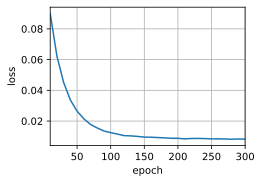

In [37]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [38]:
#@save
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """序列到序列模型的预测"""
    # 在预测时将net设置为评估模式
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # 添加批量轴
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # 添加批量轴
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # 我们使用具有预测最高可能性的词元，作为解码器在下一时间步的输入
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # 保存注意力权重（稍后讨论）
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # 一旦序列结束词元被预测，输出序列的生成就完成了
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

In [39]:
def bleu(pred_seq, label_seq, k):  #@save
    """计算BLEU"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [40]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => il est riche paresseux malade malade malade malade paresseux <pad>, bleu 0.258
i'm home . => je suis chez moi qui ai nous prie ., bleu 0.583
